In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime as dt
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [2]:


def get_weekly_report(start_date, end_date, url):
    """
    Fetches weekly volcano reports from the given URL within the specified date range.

    Parameters:
    start_date (str): The start date in the format 'YYYY-MM-DD'.
    end_date (str): The end date in the format 'YYYY-MM-DD'.
    url (str): The URL to fetch the reports from.

    Returns:
    pd.DataFrame: A DataFrame containing the scraped data.
    """
    # Turn start and end date into datetime objects
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")

    # Get the page content
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the script tag containing the options
    script_tag = soup.find('script', string=re.compile(r'function whichWeek'))

    # Extract the JavaScript code
    script_content = script_tag.string

    # Use regex to find all options
    options = re.findall(r'objWeek\.options\[(\d+)\]\.value="([^"]+)"\s*objWeek\.options\[\d+\]\.text="([^"]+)"', script_content)
    
    # List to store the data
    data = []

    # Iterate through the options and print them
    for index, value, text in options:
        # Check if value is start_date - 7 days and end_date is greater than value + 7 days 
        option_date = dt.datetime.strptime(value[:10], "%Y-%m-%d")
        if start_date - dt.timedelta(days=7) <= option_date and end_date >= option_date + dt.timedelta(days=7):
            print(f'Collecting report: {text}')
            
            # Construct the URL for the specific week
            form_data = {'selectYear': value[0:4],  # Change this to the desired year
                        'selectWeek': value}  # Change this to the desired week

            # Make the POST request with the form data
            response = requests.post(url, data=form_data)

            # Parse the response content with BeautifulSoup
            option_soup = BeautifulSoup(response.content, 'html.parser')

            # Extract the necessary data from the option_soup
            reports = option_soup.find_all('div', class_='atip')
            for report in reports:
                title = report.find('strong').text
                content = report.get_text(separator="\n", strip=True)
                data.append({'Week': text, 'Value': value, 'Title': title, 'Content': content})

    # Create a DataFrame from the data
    df_scrape = pd.DataFrame(data)
    
    # Replace the substring in 'Content' with the value from 'Title' for each row
    df_scrape['Content'] = df_scrape.apply(lambda row: row['Content'].replace(row['Title'] + '\n', ''), axis=1)
    # New column for volcano name which replaces report for from title column
    df_scrape['Volcano Name'] = df_scrape['Title'].str.replace('Report for ', '')
    df_scrape['Week'] = pd.to_datetime(df_scrape['Week'])


    return df_scrape

def generate_color_marker_combinations(N):
    """
    Generates unique color and marker combinations for a list of length N.

    Parameters:
    N (int): The length of the list.

    Returns:
    list: A list of tuples containing color and marker combinations.
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']

    # Generate all possible combinations of colors and markers
    combinations = list(itertools.product(markers,colors))

    # Ensure we have enough combinations for the list of length N
    if N > len(combinations):
        raise ValueError("N is too large, not enough unique color and marker combinations available.")

    # Select the first N combinations
    return combinations[:N]

    
def get_filtered_report(volcano_name=None, df=None, dateS=None, dateE=None, key_word=None):
    """
    Filters the DataFrame based on the given parameters and plots the filtered data.

    Parameters:
    volcano_name (str): The name of the volcano to filter by.
    df (pd.DataFrame): The DataFrame to filter.
    dateS (str): The start date in the format 'YYYY-MM-DD'.
    dateE (str): The end date in the format 'YYYY-MM-DD'.
    key_word (str): The keyword to filter the content by.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    # Filter the DataFrame for the dateS and dateE + 7 days based on week column of df
    if dateS and dateE:
        dateS = dt.datetime.strptime(dateS, "%Y-%m-%d")
        dateE = dt.datetime.strptime(dateE, "%Y-%m-%d") + dt.timedelta(days=7)  # Add 7 days to end date
        df = df[(df['Week'] >= dateS) & (df['Week'] <= dateE)]

    # Filter the DataFrame for the volcano
    if volcano_name:
        df = df[df['Volcano Name'] == volcano_name]
        
    # Check if key_word is not None
    if key_word:
        df = df[df['Content'].str.contains(key_word, case=False)]
        # Count how many times key word is mentioned in the content in each row
        df['Count'] = df['Content'].str.count(key_word)
    
    # use the date range provided to decide the most appropriate time period to group the data by
    if dateS and dateE:
        if (dateE - dateS).days <= 31:
            timeperiods = 'D'
        elif (dateE - dateS).days <= 93:
            timeperiods = 'W'
        # add extra option for months and years
        elif (dateE - dateS).days <= 365:
            timeperiods = 'M'
        else:
            timeperiods = 'Y'

    plot_volcano_report(df, key_word,timeperiods)
    
    return df

def plot_volcano_report(df=None, key_word=None,timeperiods='W'):
    """
    Plots the filtered volcano report data.

    Parameters:
    df (pd.DataFrame): The DataFrame to plot.
    key_word (str): The keyword used for filtering the content.
    timeperiods (str): The time period to group the data by (e.g., 'W' for weekly, 'M' for monthly).
    """

    # change script so that you do not need to run get_filtered_report function first and use plot pie chart function if key_word is None
    
    if df is None:
        raise ValueError('DataFrame is None. Make sure to run the get_filtered_report function first.')

    # if n_of_timeperiods is not None, group by n_of_timeperiods and plot the data
    if timeperiods != 'W':
        # Group by n_of_timeperiods
        #df['Week'] = pd.to_datetime(df['Week'])
       
        # Create a new column for period
        df['Period'] = df['Week'].dt.to_period(timeperiods)

        # choose central date of the period
        df['Period'] = df['Period'].dt.to_timestamp()
    else:
        df['Period'] = df['Week']


        # Check if df contains count column
    if 'Count' in df.columns:
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))

        unique_volcanoes = df['Volcano Name'].unique()
        # Plot the data for each volcano as a new histogram at each date of occurrence
        for color_marker,volcano in zip(generate_color_marker_combinations(len(unique_volcanoes)),unique_volcanoes):
            # Filter the DataFrame for the volcano
            df_volcano = df[df['Volcano Name'] == volcano]

            # Plot the data
            ax.plot(df_volcano['Period'], df_volcano['Count'],color = color_marker[1], marker=color_marker[0], label=volcano) 
        # Add legend
        ax.legend()
        # Rotate the x-axis labels
        plt.xticks(rotation=45)
        # Set the title and labels
        plt.title('Number of Reports for each volcano containing the word {}'.format(key_word))
        plt.xlabel('Week')
        plt.ylabel('Count')

        # Create seaborn plot of bar chart of count for each week  
        fig, ax = plt.subplots(figsize=(10, 6)) 
        sns.barplot(data=df, x='Period', y='Count', hue='Volcano Name', ax=ax)
        # make legend outside of plot on the right
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Find earliest and latest date in dataframe
    start_date = df['Week'].min()
    end_date = df['Week'].max()
    # Plot pie chart 
    if len(df['Volcano Name'].unique()) > 1:
        plot_volcano_pie_chart(df, start_date, end_date,yearly=True)

    # Show the plot
    plt.show()

    return df

def plot_volcano_pie_chart(df, start_date, end_date,yearly=False):
    """
    Plots a pie chart for the occurrence of each volcano name within the specified date range.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the volcano report data.
    start_date (str): The start date in the format 'YYYY-MM-DD'.
    end_date (str): The end date in the format 'YYYY-MM-DD'.
    """

       # check if start and end date are already datetime objects
    if isinstance(start_date, str) and isinstance(end_date, str):
            
        # Convert start and end date to datetime objects
        start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
        end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    # If yearly is True, group by year and plot pie chart for each year in the date range
    if yearly:
        # Filter the DataFrame for the specified date range
        df_filtered = df[(df['Week'] >= start_date) & (df['Week'] <= end_date)]

        # Extract the year from the 'Week' column
        df_filtered['Year'] = df_filtered['Week'].dt.year

        # Iterate through the unique years
        for year in df_filtered['Year'].unique():
            # Filter the DataFrame for the year
            df_year = df_filtered[df_filtered['Year'] == year]

            # Count the occurrences of each volcano name
            volcano_counts = df_year['Volcano Name'].value_counts()

            # Create a pie chart
            plt.figure(figsize=(10, 6))
            plt.pie(volcano_counts, labels=volcano_counts.index, autopct='%1.1f%%', startangle=140)
            plt.title(f'Volcano Occurrences in {year}')
            plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            # make legend outside of plot on the right
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=4,title='Volcano Name')
            # Show the plot
            plt.show()
        return
    # Convert start and end date to datetime objects
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")

    # Filter the DataFrame for the specified date range
    df_filtered = df[(df['Week'] >= start_date) & (df['Week'] <= end_date)]

    # Count the occurrences of each volcano name
    volcano_counts = df_filtered['Volcano Name'].value_counts()

    # Create a pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(volcano_counts, labels=volcano_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Volcano Occurrences from {start_date.date()} to {end_date.date()}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # make legend outside of plot on the right
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # make legend have columns with 10 rows in each column 
    plt.legend(volcano_counts.index, loc='center left', bbox_to_anchor=(1, 0.5), ncol=4, title='Volcano Name')
    # Show the plot
    plt.show()
    return 

# Generate a function that saves dataframe to a csv file and another function that reads csv file to pandas dataframe
def save_to_csv(df, filename):
    """
    Saves the DataFrame to a CSV file.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    filename (str): The filename to save the DataFrame to.
    """
    df.to_csv(filename, index=False)
def read_from_csv(filename):
    """
    Reads a DataFrame from a CSV file.

    Parameters:
    filename (str): The filename to read the DataFrame from.

    Returns:
    pd.DataFrame: The DataFrame read from the CSV file.
    """
    df = pd.read_csv(filename)

    # make sure column types are the same as expected 
    df['Week'] = pd.to_datetime(df['Week'])
    # if period column exists convert to datetime object
    if 'Period' in df.columns:
        df['Period'] = pd.to_datetime(df['Period'])
    
    return df

In [3]:
# URL of the page
url = "https://volcano.si.edu/reports_weekly.cfm"
# Start and end date for the report
start_date = "2024-10-01"

# end_date is current date in correct format
end_date = dt.datetime.now().strftime('%Y-%m-%d')
# Get the weekly report and return the DataFrame
df_scrape = get_weekly_report(start_date, end_date, url)


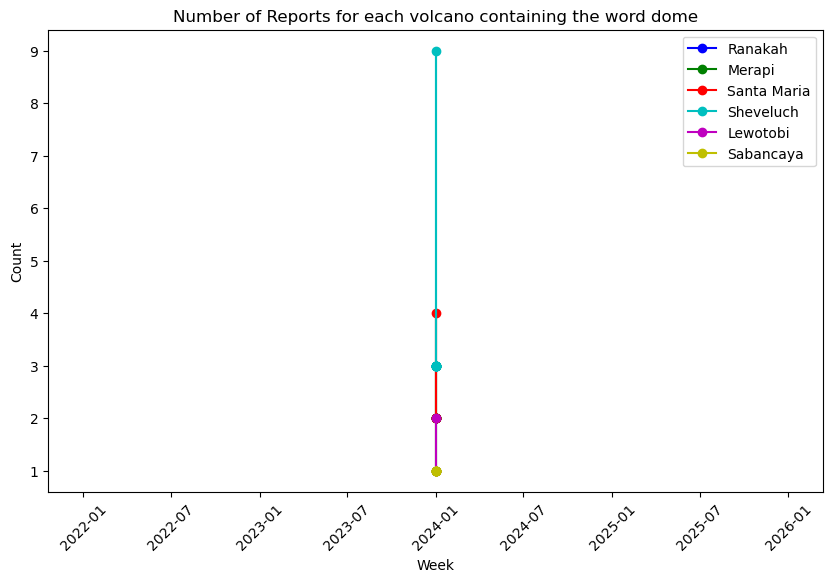

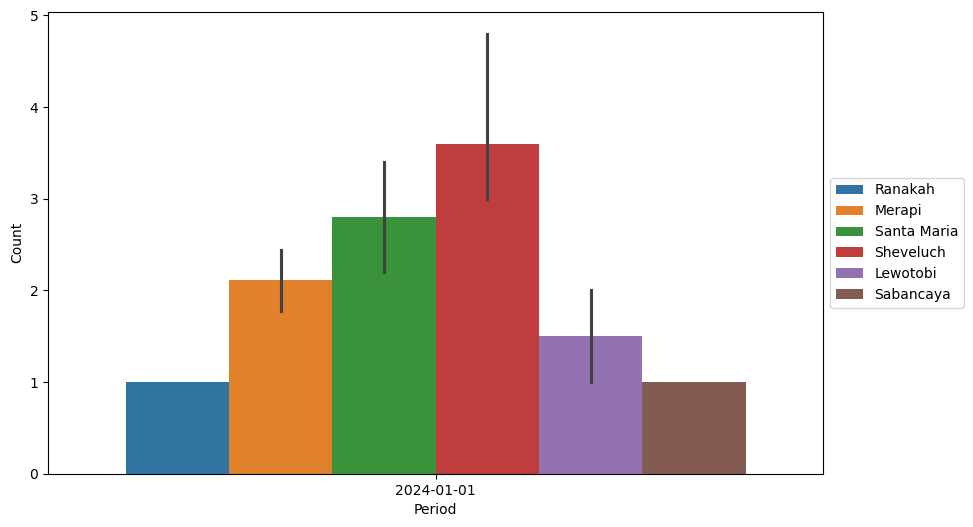

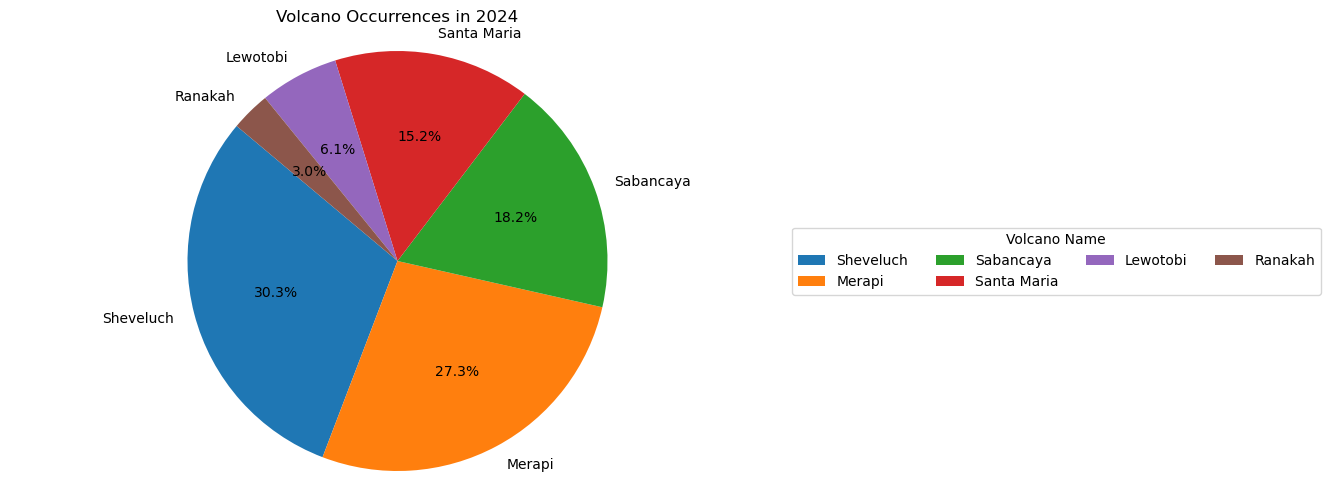

In [4]:
# get filtered report for a specific volcano, date range and key word
df = get_filtered_report(volcano_name=None, df=df_scrape, dateS='2016-01-01', dateE='2024-12-01', key_word='dome')




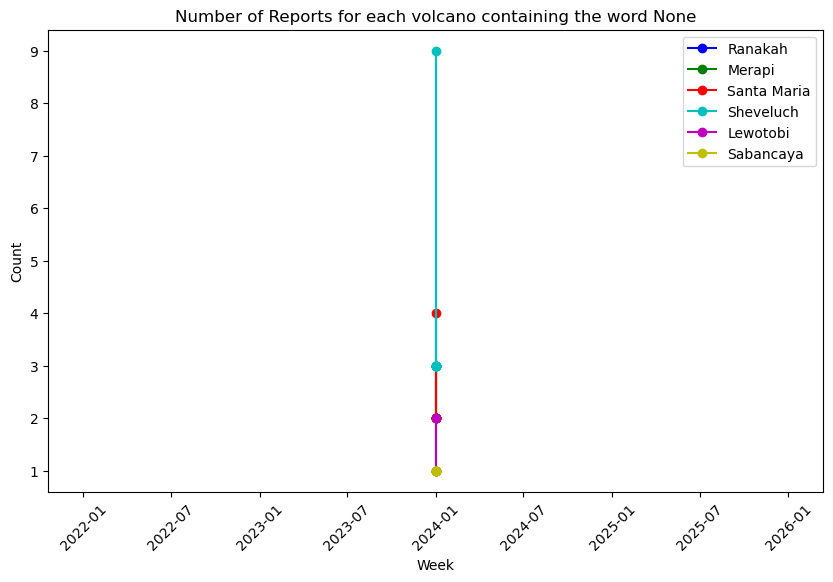

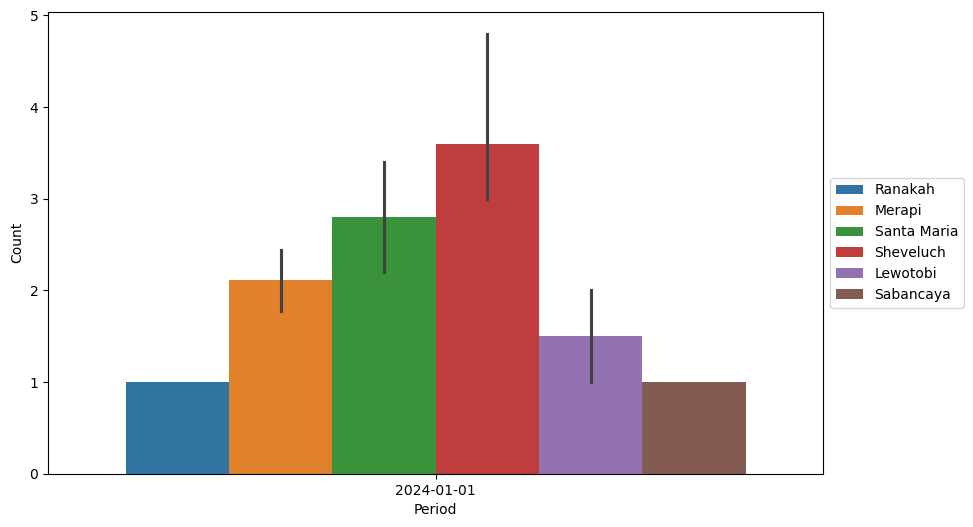

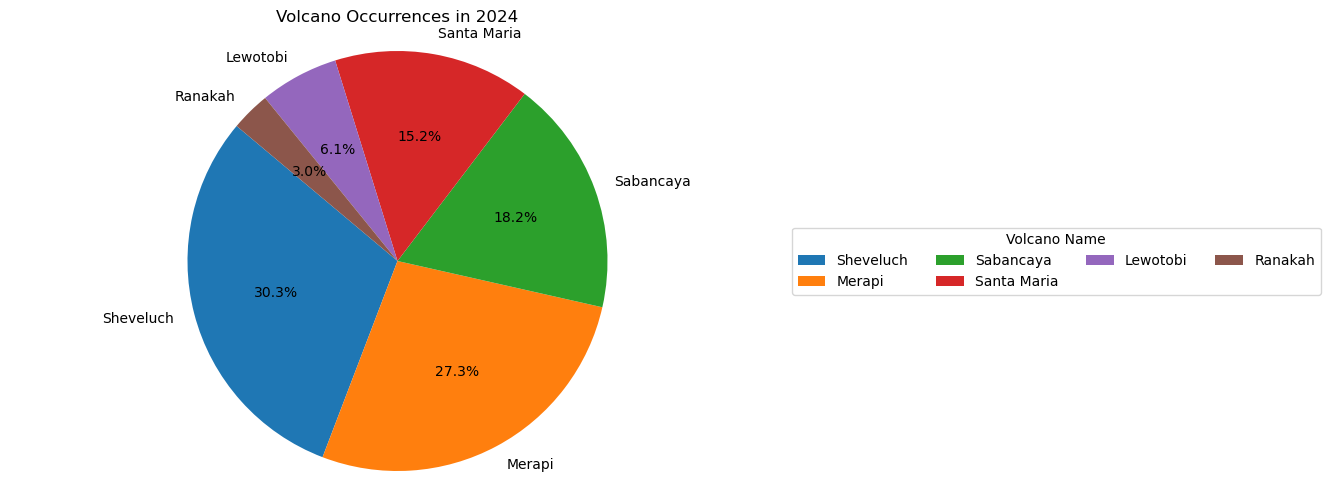

In [5]:
now_str  = dt.datetime.now().strftime('%y%m%d_%H%M')
save_to_csv(df, f'volcano_reports_{now_str}.csv')
# Load Example DataFrame from the CSV file
df = read_from_csv(f'volcano_reports_{now_str}.csv')
df = plot_volcano_report(df=df,timeperiods='Y')

### Extended Date Range 

In [ ]:
# URL of the page
url = "https://volcano.si.edu/reports_weekly.cfm"
# Start and end date for the report
start_date = "2020-01-01"

# Full date range takes approximately 2 hours to scrape

#ask user if they want to scrape the full date range
full_range = 'Y' #input('Do you want to scrape the full date range? (Y/N): ')
if full_range.lower() == 'y':
    # end_date is current date in correct format
    end_date = dt.datetime.now().strftime('%Y-%m-%d')
    # Get the weekly report and return the DataFrame
    df_full = get_weekly_report(start_date, end_date, url)
    now_str  = dt.datetime.now().strftime('%y%m%d_%H%M')
    



In [ ]:
save_to_csv(df_full, f'full_volcano_reports.csv')

In [ ]:
# Load Example DataFrame from the CSV file
df = read_from_csv(f'full_volcano_reports.csv')


TimeoutError: [Errno 60] Operation timed out

In [ ]:
df = plot_volcano_report(df=df,timeperiods='Y')

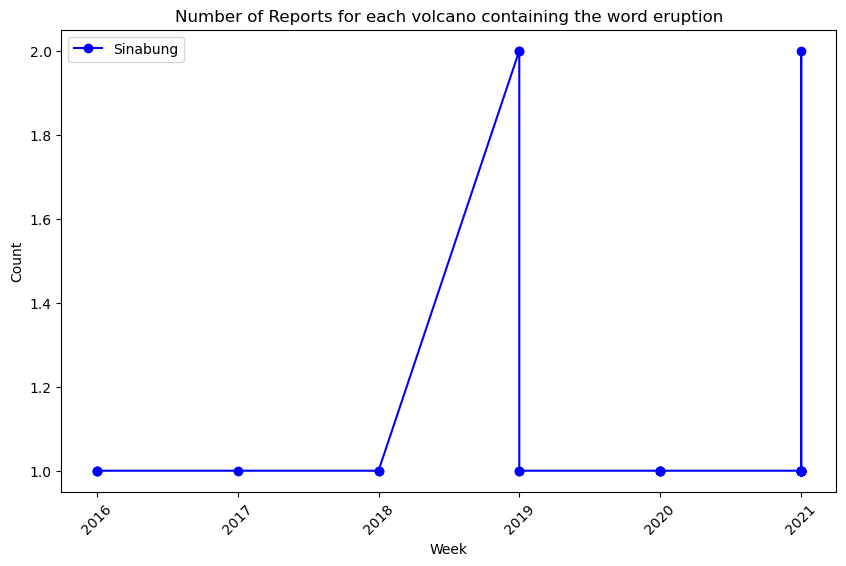

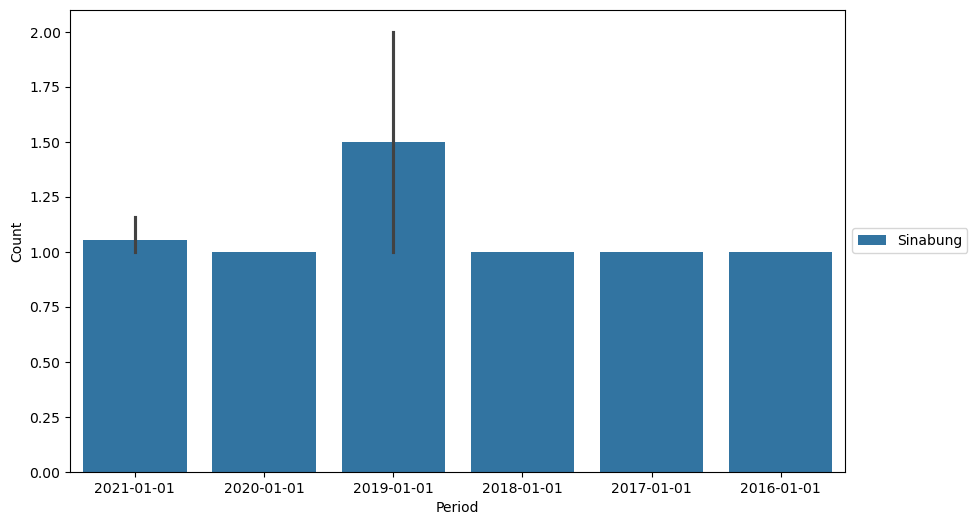

In [ ]:
df_full = read_from_csv(f'full_volcano_reports.csv')
# get filtered report for a specific volcano, date range and key word
df = get_filtered_report(volcano_name='Sinabung', df=df_full, dateS='2020-01-01', dateE='2024-12-01', key_word='eruption')


In [ ]:
df_full = read_from_csv(f'full_volcano_reports.csv')
# get filtered report for a specific volcano, date range and key word
df = get_filtered_report(volcano_name='Sinabung', df=df_full, dateS='2020-06-01', dateE='2020-08-15', key_word=None)
